In [4]:
# testing for exact TN charge gap parameter
import sys
sys.path.append("..")

from dmet.model import hubbard
from pyscf import fci
from pyscf.scf import hf
import numpy as np
from cpskit.fci import ci_slater
import scipy.linalg as la
from eomdp.fcicis import get_fciao_cis_wfns
from pyscf import ao2mo


def zero_out_ci(ci, mol, Fstrsa, Fstrsb, imp_idx, occa, occb):
    ''' 
    ci of a large fragment F
    Fstrsa, Fstrsb are cistrings of F
    imp_idx is the index of the small imp orb in F's EOs
    return a ci vector with non-zeros for configs that has imp orb (occa, occb)
    '''
    assert ci.shape[0] == len(Fstrsa)
    assert ci.shape[1] == len(Fstrsb)
    norb = mol.nao
    nci = ci.copy()
    def int2str(i):
        res = bin(i)[2:][::-1]
        return res + "0" * (norb-len(res))
    for addra in range(len(Fstrsa)):
        Fstra = int2str(Fstrsa[addra])
        if Fstra[imp_idx] != occa:
            nci[addra,:] = 0
            continue
        for addrb in range(len(Fstrsb)):
            Fstrb = int2str(Fstrsb[addrb])
            if Fstrb[imp_idx] != occb:
                nci[addra, addrb] = 0
    return nci

def get_matching_fci(ci, imp_idx, mol, normalize=True, debug=False):
    '''
    get fci vectors form the exact fci vector that match the f configs
    '''
    Fstrs = fci.cistring.make_strings(range(mol.nao), mol.nelectron//2)
    c = list()
    for occa in ['1', '0']:
        for occb in ['1', '0']:
            # extract the states where F config consistent with this f config
            cP_ = zero_out_ci(ci, mol, Fstrs, Fstrs, imp_idx, occa, occb)
            if normalize:
                c.append(cP_ / la.norm(cP_))
            else:
                c.append(cP_)
    return c

def get_cgintens(civec, norb, nelec):   
    r'''
    .. math::
        \xi = \sum\limits_{I^\alpha I^\beta} N(I^\alpha I^\beta) |\psi_{I^\alpha I^\beta}| ^ 2
    '''

    def get_cgnum(a, b, norb):

        c = a & b
        alst = [c&(2**x) for x in range(norb)]
        k = 0
        for i in alst:
            if i != 0: k += 1
        del alst
        return k

    strings = fci.cistring.make_strings(range(norb), nelec)

    intens = 0

    for a, stra in enumerate(strings):
        for b, strb in enumerate(strings):
            cgnum = get_cgnum(stra, strb, norb)
            psi = civec[a,b]
            intens += cgnum * psi * psi.conj()
    
    return intens

def hs_1imp(wfnlst, nocc, nvir, h1e, eri):  # for fci wave-function list

    nstate = len(wfnlst)
    
    h = np.zeros((nstate, nstate))
    s = np.zeros((nstate, nstate))

    for i in range(nstate):

        cibra = wfnlst[i]
        for j in range(nstate):

            ciket = wfnlst[j]

            s[i,j] += np.einsum("ij,ij->", cibra.conj(), ciket)
            dm1, dm2 = fci.direct_spin1.trans_rdm12(cibra, ciket, nocc+nvir, (nocc,nocc))
            h[i,j] += np.einsum("ij,ij->", h1e, dm1) + .5 * np.einsum("ijkl,ijkl->", eri, dm2)

    return h, s

def FCI_Atomic(mf): 
    # imitating pyscf.fci.__init__.FCI(), reset h1e, eri and ci0 to SITE basis.

    mol = mf.mol
    mo_c = mf.mo_coeff
    h1e = mf.get_hcore()
    norb = mo_c.shape[1]
    eri = mf._eri
    nelec = getattr(mf, 'nelec', mol.nelec)
    mo_c_occ = mf.mo_coeff[:,np.where(mf.mo_occ==2)[0]]
    ci0 = ci_slater(norb, nelec, (mo_c_occ, mo_c_occ))

    fcisolver = fci.direct_spin1.FCISolver(mol)
    fcisolver_class = fcisolver.__class__
    class CISolver(fcisolver.__class__):
        def __init__(self, mol=None):
            fcisolver_class.__init__(self, mol)
            self.orbsym = None

        def kernel(self, h1e=h1e, eri=eri, norb=norb, nelec=nelec, ci0=ci0,
                   ecore=0., **kwargs):
            return fcisolver_class.kernel(self, h1e, eri, norb, nelec, ci0,
                                          ecore=ecore, **kwargs)
    
    cisolver = CISolver(mol)
    cisolver.__dict__.update(fcisolver.__dict__)
    cisolver.orbsym = None
    return cisolver

mixint_lst = [[], [], [], [], []]
mixext_lst = [[], [], [], []]

def calc(U, ny):

    mol = hubbard.HubbardMole(1, ny, 1, U)
    mol.nelectron = ny
    nocc = nvir = nelec = ny // 2
    norb = ny
    mf = hubbard.RHF_SpinHubbard(mol)
    mf.pbc = True
    mf.kernel()

    fcisolver = FCI_Atomic(mf)    # change ci into LO basis
    fullE, fullci = fcisolver.kernel(nroots=10)
    print("FCI = ", fullE)
    spinoplst = [round(fci.spin_op.spin_square(cis, norb, (nelec, nelec))[0]) for cis in fullci]
    print("S^2 of FCI vectors: ", spinoplst)
    ci = fullci[0]

    # save the intensity of GS
    mixint = get_cgintens(ci, norb, nelec)
    print("Charge gap of GS: ", mixint)
    mixint_lst[4].append(mixint)

    # save the intensity of FCI first excited states
    mixext_lst[3].append(fullE[1] - fullE[0])
    mixint = get_cgintens(fullci[1], norb, nelec)
    print("Charge gap parameter of first triplet FCI: ", mixint)
    mixint_lst[3].append(mixint)


    eri = ao2mo.restore(1, mf._eri, ny)
    h1e = mf.get_hcore()

    dimHf = 4   # dimension of Hilbert space
    simps = [0] * ny

    wfnlst_TN = []
    
    for i in range(len(simps)):
        cs = get_matching_fci(ci, i, mol)
        for j in range(dimHf):
            wfnlst_TN.append(cs[j])

    wfnlst_EOM = get_fciao_cis_wfns(ci, nocc, nvir, mf.mo_coeff)

    wfnlst = wfnlst_TN + wfnlst_EOM # merge the EOM and TN basis sets
    exact_H, exact_S = hs_1imp(wfnlst, nocc, nvir, h1e, eri)

    ranglst = [range(len(wfnlst_TN)), range(len(wfnlst_TN), len(wfnlst)), range(len(wfnlst))]

    for i, rang in enumerate(ranglst):
        print("Calc ansatz {} ...".format(i+1))

        exact_Sp = exact_S[np.ix_(rang, rang)]
        exact_Hp = exact_H[np.ix_(rang, rang)]

        wS_exact, vS_exact = la.eigh(exact_Sp)
        mask = wS_exact > 1e-5
        S_proj = vS_exact.T[mask] @ (exact_Sp+exact_Sp.T)/2 @ vS_exact[:,mask]
        H_proj = vS_exact.T[mask] @ (exact_Hp+exact_Hp.T)/2 @ vS_exact[:,mask]
        wHp_exact, vHp_exact = hf.eig(H_proj, S_proj)   # solve in truncated area

        print("Energy for Ansatz {} = ".format(i+1), wHp_exact[:10])
        mixext_lst[i].append(wHp_exact[1] - wHp_exact[0])

        coeff_in_basis = vS_exact[:,mask] @ vHp_exact

        wfnbasis = np.array(wfnlst)[rang,:,:]

        res_wfn = np.einsum("iab,ij->jab", wfnbasis, coeff_in_basis)
        spinoplst = [round(fci.spin_op.spin_square(res_wfn[i], norb, (nelec, nelec))[0]) for i in range(10)]
        print("S^2 for Ansatz {}: ".format(i+1), spinoplst)
        cgparam = get_cgintens(res_wfn[1], norb, nelec)
        print("Charge gap parameter of first triplet of Ansatz {} = ".format(i+1), cgparam)

        mixint_lst[i].append(cgparam)


ny = 10

ulst = np.linspace(1, 50, 50)
for U in ulst: calc(U, ny)

import pandas as pd

df = pd.DataFrame()
df['U'] = ulst
df['ext-TN'], df['ext-EOM'], df['ext-MIX'], df['ext-FCI'] = mixext_lst
df['int-TN'], df['int-EOM'], df['int-MIX'], df['int-FCI'], df['int-GS'] = mixint_lst

df.to_csv("./10/hubbard_10.csv", index=False)


converged SCF energy = -10.4442719099992


Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd6851a130> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd6851a100>


FCI =  [-10.61440716  -9.59891428  -9.47853761  -9.47853761  -9.45342693
  -8.6390188   -8.63894842  -8.58343849  -8.58112455  -8.49812546]
S^2 of FCI vectors:  [0, 2, 2, 2, 0, 2, 2, 2, 2, 1]
Charge gap of GS:  2.1573777749176077
Charge gap parameter of first triplet FCI:  1.9174690156344725
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-10.61440716  -9.46750035  -9.46750035  -9.25043365  -9.25043365
  -8.58204407  -8.56552461  -8.56552461  -8.15077099  -8.15077099]
S^2 for Ansatz 1:  [0, 2, 2, 0, 0, 2, 2, 2, 0, 0]
Charge gap parameter of first triplet of Ansatz 1 =  2.0952014021752707
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-10.61440716  -9.56798675  -9.40783094  -9.40783094  -9.30383875
  -9.30334231  -9.20795162  -9.20795161  -9.15248906  -8.55575258]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 0, 0, 0, 0, 2]
Charge gap parameter of first triplet of Ansatz 2 =  1.9630977807798566
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-10.61440716  -9.57669678  -9.46941102  -9.46941102  -9.30383875
  -9.303

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd6851a040> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd6851a370>


FCI =  [-8.63841574 -7.86996456 -7.66328494 -7.61473397 -7.61473397 -7.00357694
 -7.00357677 -6.8398069  -6.83301443 -6.82395894]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 2, 6, 2]
Charge gap of GS:  1.7887406951819258
Charge gap parameter of first triplet FCI:  1.5445189445148784
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-8.63841574 -7.5798963  -7.57989628 -7.12899742 -7.03023334 -7.0302333
 -6.77473523 -6.77473521 -6.47444262 -6.47444259]
S^2 for Ansatz 1:  [0, 2, 2, 2, 0, 0, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  1.7490475810031043
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-8.63841574 -7.76741357 -7.29859145 -7.29859144 -7.08362986 -7.07459786
 -6.90075442 -6.90075441 -6.85211593 -6.70186542]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 0, 0, 0, 0, 2]
Charge gap parameter of first triplet of Ansatz 2 =  1.560123038388116
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-8.63841574 -7.80635413 -7.58850326 -7.58850325 -7.08362986 -7.07459786
 -7.03028403 -7.03028399 -6.86361

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd690c1580> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8188bb0>


FCI =  [-7.0460599  -6.49762778 -6.27784843 -6.15151856 -6.15151856 -5.7375829
 -5.73758289 -5.52769256 -5.50417949 -5.48983341]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 2, 0]
Charge gap of GS:  1.3955176688544995
Charge gap parameter of first triplet FCI:  1.2081272058551829
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-7.0460599  -6.09321379 -6.09321363 -5.96627044 -5.38959    -5.38958995
 -5.238224   -5.23822391 -5.07645166 -5.07645159]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  1.37041064540897
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-7.0460599  -6.29664777 -5.34884298 -5.34884293 -5.13942201 -5.13942193
 -5.02253683 -4.9760062  -4.77824145 -4.77824141]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 0, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  1.1345169152767898
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-7.0460599  -6.40360222 -6.11025377 -6.11025371 -5.59014749 -5.59014728
 -5.45970899 -5.45970895 -5.258809

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd690c1580> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8188bb0>


FCI =  [-5.83432264 -5.43485464 -5.22448236 -5.06806509 -5.06806509 -4.77559543
 -4.77559543 -4.56320878 -4.5374202  -4.53699   ]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  1.040850326793052
Charge gap parameter of first triplet FCI:  0.9278713295269837
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-5.83432264 -5.04145189 -4.99681137 -4.99681132 -4.3931618  -4.3931618
 -4.34416603 -4.344166   -4.15034437 -4.15034436]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.7465497826324384
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-5.83432264 -5.112941   -3.85700385 -3.85700372 -3.51299145 -3.51299137
 -3.23785023 -3.23785021 -3.20687909 -3.20687904]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.7792707139506845
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-5.83432264 -5.32740892 -5.01715269 -5.01715268 -4.65008614 -4.65008606
 -4.47835309 -4.47835308 -4.34431

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb816d490> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb065ca60>


FCI =  [-4.9334364  -4.62056278 -4.42758251 -4.2749829  -4.2749829  -4.04849977
 -4.04849977 -3.85572569 -3.83063898 -3.83017726]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.7763956835295871
Charge gap parameter of first triplet FCI:  0.711055223825309
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-4.9334364  -4.31376624 -4.20047107 -4.20047102 -3.69161976 -3.69161973
 -3.68213138 -3.68213137 -3.49158755 -3.49158755]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.5577083946624216
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-4.9334364  -4.18468283 -2.83007922 -2.83007911 -2.0527345  -2.05273449
 -1.80666364 -1.80666363 -1.77861629 -1.77861624]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.5361951114050448
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-4.9334364  -4.51085906 -4.21936644 -4.21936642 -3.93966227 -3.93966221
 -3.76385701 -3.76385701 -3.6673

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd780193a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684d8c10>


FCI =  [-4.25455941 -3.99382171 -3.8193309  -3.68131998 -3.68131998 -3.49365045
 -3.49365045 -3.32432296 -3.29718076 -3.29687369]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.5925587167449701
Charge gap parameter of first triplet FCI:  0.5508115628322321
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-4.25455941 -3.74439285 -3.60819635 -3.60819634 -3.19729037 -3.19729035
 -3.15773147 -3.15773145 -3.00402583 -3.00402579]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.4272593239898763
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-4.25455941 -3.46536646 -2.00568953 -2.00568909 -1.03949483 -1.03949476
 -0.5463195  -0.54631945 -0.15854607 -0.15854604]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.3803696762416283
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-4.25455941 -3.88766163 -3.62449809 -3.62449807 -3.3955454  -3.39554526
 -3.23021942 -3.23021942 -3.154

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd6920dbb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8188bb0>


FCI =  [-3.73006115 -3.50447172 -3.34697443 -3.2242644  -3.2242644  -3.06261053
 -3.06261053 -2.91389863 -2.885593   -2.88535647]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.46378873495967593
Charge gap parameter of first triplet FCI:  0.43402094751582676
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-3.73006115 -3.29520233 -3.15439268 -3.15439264 -2.81178927 -2.81178924
 -2.75765368 -2.75765367 -2.63012621 -2.63012619]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.33540588607461036
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-3.73006115 -2.8996216  -1.32658124 -1.32658082 -0.15147214 -0.15147208
  0.60829087  0.6082909   1.34740551  1.34740558]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.2792205540197062
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-3.73006115 -3.40427312 -3.16833964 -3.16833961 -2.97238372 -2.9723836
 -2.82074651 -2.82074651 -2.7

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684d9bb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb057d3a0>


FCI =  [-3.31499673 -3.11543773 -2.9727808  -2.86342836 -2.86342836 -2.72095332
 -2.72095332 -2.58916226 -2.56080628 -2.56056209]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.37120775256086297
Charge gap parameter of first triplet FCI:  0.3483666921118521
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-3.31499673 -2.93548525 -2.79746894 -2.79746892 -2.50439806 -2.50439805
 -2.44384728 -2.44384726 -2.33544245 -2.33544241]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.26900847270381945
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-3.31499673 -2.4433226  -0.74956682 -0.74956637  0.6471896   0.64718976
  1.6848413   1.68484133  2.75397448  2.75397454]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.21148466863411516
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-3.31499673 -3.02184355 -2.8095082  -2.80950818 -2.63719038 -2.63719032
 -2.4987726  -2.49877259 -2.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd780193a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684d8f10>


FCI =  [-2.97960791 -2.80048349 -2.67057214 -2.57237153 -2.57237153 -2.44486581
 -2.4448658  -2.32689355 -2.29912627 -2.29892278]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.30288197877190637
Charge gap parameter of first triplet FCI:  0.2845724650890461
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.97960791 -2.64270152 -2.51043367 -2.51043365 -2.25462889 -2.25462888
 -2.19197769 -2.19197768 -2.09796163 -2.09796162]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.2198138091916495
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.97960791 -2.06591834 -0.2455204  -0.24552029  1.38118767  1.38118773
  2.70323073  2.70323075  4.07974273  4.07974276]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.16472975590507885
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.97960791 -2.71333819 -2.52095294 -2.52095292 -2.36669496 -2.36669495
 -2.24009423 -2.24009423 -2.1

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd780193a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684d8be0>


FCI =  [-2.70369092 -2.5411805  -2.42218745 -2.33324612 -2.33324612 -2.21783888
 -2.21783888 -2.11119226 -2.08442552 -2.08427957]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.25126732965987764
Charge gap parameter of first triplet FCI:  0.23618315845057836
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.70369092 -2.40068473 -2.27518228 -2.27518226 -2.04830652 -2.0483065
 -1.98584216 -1.98584215 -1.90295344 -1.90295344]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.1825490601626974
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.70369092 -1.74671784  0.20499984  0.20499992  2.06730165  2.0673017
  3.67744504  3.67744507  5.34146497  5.34146504]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.1316082657056161
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.70369092 -2.46001865 -2.28448171 -2.28448169 -2.14461257 -2.14461255
 -2.02833719 -2.02833719 -1.985

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684eabb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd68784f70>


FCI =  [-2.4731528  -2.32446288 -2.21485453 -2.13365438 -2.13365438 -2.0282575
 -2.0282575  -1.93103959 -1.90542115 -1.90535427]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.21146717272911575
Charge gap parameter of first triplet FCI:  0.19880232487455476
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.4731528  -2.19780076 -2.07920643 -2.0792064  -1.87538352 -1.8753835
 -1.81430288 -1.81430287 -1.74023063 -1.74023063]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.1537573781430421
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.4731528  -1.47149122  0.61524508  0.61524514  2.71712427  2.71712433
  4.61743021  4.61743025  6.55263744  6.55263749]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.10762736166260488
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.4731528  -2.24873056 -2.08751409 -2.08751407 -1.95944487 -1.95944486
 -1.85214828 -1.85214828 -1.81

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684d9bb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb057d3a0>


FCI =  [-2.2779185  -2.14091747 -2.03942283 -1.96476277 -1.96476277 -1.8677938
 -1.86779379 -1.77849547 -1.75409505 -1.75406405]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.18021512847778653
Charge gap parameter of first triplet FCI:  0.16942684272388273
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.2779185  -2.02557193 -1.91363572 -1.91363569 -1.72859052 -1.72859051
 -1.66949241 -1.6694924  -1.60255518 -1.60255517]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.13111610756661968
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.2779185  -1.23021391  0.99449335  0.99449349  3.33885707  3.33885717
  5.53040615  5.53040622  7.72370143  7.72370147]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.08994395077809311
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.2779185  -2.07006664 -1.92112593 -1.92112591 -1.80294157 -1.80294155
 -1.70346771 -1.70346771 -1.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7ae0ab20> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684d8be0>


FCI =  [-2.11062528 -1.9836401  -1.88920746 -1.82013342 -1.82013342 -1.73035884
 -1.73035884 -1.64782459 -1.62466491 -1.62458353]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 1, 0]
Charge gap of GS:  0.15527707324919143
Charge gap parameter of first triplet FCI:  0.14597873934190853
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-2.11062528 -1.8777245  -1.77203216 -1.77203214 -1.60256766 -1.60256764
 -1.54571853 -1.54571852 -1.48466263 -1.48466262]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.11302857833106647
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-2.11062528 -1.01564894  1.34941237  1.34941268  3.93844111  3.9384413
  6.421726    6.42172614  8.86264675  8.8626469 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.0767027604315054
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-2.11062528 -1.91716529 -1.7788398  -1.77883978 -1.66907386 -1.66907385
 -1.57644641 -1.57644641 -1.5

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7807a3a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7ae0ab20>


FCI =  [-1.96578557 -1.84747606 -1.75923208 -1.69497867 -1.69497867 -1.6114165
 -1.6114165  -1.53466039 -1.51264131 -1.51258406]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.13509022577517912
Charge gap parameter of first triplet FCI:  0.1269960217632624
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.96578557 -1.74954142 -1.64962501 -1.64962501 -1.49329284 -1.49329283
 -1.43877366 -1.43877365 -1.38264349 -1.38264348]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.0983738821122259
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.96578557 -0.82245367  1.68490722  1.68490747  4.52027409  4.52027431
  7.29543637  7.29543648  9.9755983   9.97559841]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.06666014614252164
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.96578557 -1.78492546 -1.65585588 -1.65585588 -1.55335566 -1.55335565
 -1.46675296 -1.46675296 -1.43

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb057d3a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7add4a30>


FCI =  [-1.83923622 -1.72851157 -1.64572692 -1.58567289 -1.58567289 -1.50752819
 -1.50752818 -1.43584115 -1.41490102 -1.41481969]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 0, 0]
Charge gap of GS:  0.11853916687395054
Charge gap parameter of first triplet FCI:  0.11143204731938515
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.83923622 -1.6374215  -1.54281218 -1.54281217 -1.39769841 -1.3976984
 -1.34548709 -1.34548707 -1.29353983 -1.29353981]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.08634981820694282
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.83923622 -0.64660619  2.00466058  2.00466099  5.08767518  5.08767556
  8.15464843  8.15464861 11.06728484 11.06728496]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.058962600543588616
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.83923622 -1.66948723 -1.54855046 -1.54855045 -1.45239103 -1.45239101
 -1.37112009 -1.37112008 -1

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd690befa0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb065c910>


FCI =  [-1.72776801 -1.62372861 -1.54579004 -1.48942527 -1.48942527 -1.41604541
 -1.41604541 -1.34881443 -1.32892279 -1.3287819 ]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 1, 0]
Charge gap of GS:  0.10481264125049927
Charge gap parameter of first triplet FCI:  0.09852459025086796
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.72776801 -1.53857525 -1.44882831 -1.44882829 -1.31340948 -1.31340947
 -1.26342848 -1.26342847 -1.21507639 -1.21507637]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.0763717356769154
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.72776801 -0.48502323  2.31148875  2.31148939  5.64319297  5.6431934
  9.00179157  9.00179177 12.14139415 12.14139434]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.053011805360022556
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.72776801 -1.56788211 -1.45414179 -1.45414177 -1.36356816 -1.36356814
 -1.28704204 -1.28704203 -1.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684d8f10> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb057d3a0>


FCI =  [-1.62887103 -1.53076646 -1.45715479 -1.40405579 -1.40405579 -1.33489849
 -1.33489849 -1.27157795 -1.2526723  -1.25248598]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 1, 0]
Charge gap of GS:  0.09331073501408357
Charge gap parameter of first triplet FCI:  0.08770951899274164
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.62887103 -1.45081299 -1.3655179  -1.36551789 -1.23856219 -1.23856218
 -1.19070585 -1.19070584 -1.14547652 -1.1454765 ]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.06800658781952408
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.62887103 -0.33530476  2.60757988  2.60758012  6.1888148   6.18881525
  9.838788    9.83878823 13.20083212 13.20083246]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.048380521895108664
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.62887103 -1.47779335 -1.37046187 -1.37046186 -1.28484897 -1.28484895
 -1.21256776 -1.21256776 -

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7807a3a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684deb20>


FCI =  [-1.54055643 -1.44775449 -1.3780271  -1.32783871 -1.32783871 -1.26244858
 -1.26244858 -1.20262356 -1.18458831 -1.18438671]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 1, 0]
Charge gap of GS:  0.08358277052300238
Charge gap parameter of first triplet FCI:  0.0785629984382573
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.54055643 -1.37239434 -1.29117804 -1.29117802 -1.17167534 -1.17167533
 -1.12582595 -1.12582595 -1.08333431 -1.08333429]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.06092860937474866
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.54055643 -0.19555496  2.89465791  2.89465894  6.72611136  6.72611194
 10.66717784 10.66717807 14.24791323 14.24791366]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.04475839220768699
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.54055643 -1.39738849 -1.29579804 -1.29579801 -1.21462185 -1.21462183
 -1.14615744 -1.14615744 -1.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7807a3a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684deb20>


FCI =  [-1.4612294  -1.37319272 -1.30696975 -1.25939133 -1.25939133 -1.19738238
 -1.19738238 -1.14068481 -1.12341715 -1.12324902]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 1, 0]
Charge gap of GS:  0.07528561219946887
Charge gap parameter of first triplet FCI:  0.07076214262341432
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.4612294  -1.30192064 -1.22444626 -1.22444624 -1.11155818 -1.11155817
 -1.06759501 -1.06759499 -1.02752325 -1.02752322]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.0548895011655979
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.4612294  -0.06426038  3.1741025   3.17410297  7.25634113  7.25634224
 11.48820799 11.4882086  15.28449806 15.2844986 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.04191664661319839
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.4612294  -1.32520041 -1.2287802  -1.22878018 -1.15159693 -1.15159691
 -1.0865804  -1.08658038 -1.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7818cd30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb056dbb0>


FCI =  [-1.38959719 -1.30586531 -1.24281869 -1.19759363 -1.19759363 -1.13863588
 -1.13863588 -1.08474995 -1.06819113 -1.06805521]
S^2 of FCI vectors:  [0, 2, 0, 2, 2, 2, 2, 6, 1, 0]
Charge gap of GS:  0.06815435896650109
Charge gap parameter of first triplet FCI:  0.06405777865316395
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.38959719 -1.23825576 -1.16422064 -1.16422063 -1.05724367 -1.05724365
 -1.01504822 -1.0150482  -0.97713105 -0.97713102]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.049697399307812556
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.38959719  0.05980518  3.44702312  3.44702359  7.78052234  7.78052335
 12.3028985  12.30289904 16.31209962 16.31210011]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03968434717310646
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.38959719 -1.26004159 -1.16830037 -1.16830035 -1.09473056 -1.09473054
 -1.03284223 -1.03284222 -

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684deb20> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7ae0ab20>


FCI =  [-1.32386438 -0.94049218 -0.78691084 -0.77237465 -0.76559021 -0.75513234
 -0.617788   -0.56886602 -0.55723914 -0.54592102]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.05710768874669988
Charge gap parameter of first triplet FCI:  0.04173098043831603
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.3226374  -1.17035561 -1.11512778 -1.11511179 -1.00995928 -1.00915996
 -0.97612644 -0.97588645 -0.938025   -0.93773262]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.041464126974426516
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.32068503  0.27820077  3.63410789  3.64392661  8.20465221  8.2245719
 13.10435611 13.12683079 17.3770723  17.3851933 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.039352471851068875
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.32263857 -1.20036121 -1.11805809 -1.11801102 -1.0431328  -1.0426768
 -0.98906059 -0.98887531 -0

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd6851a130> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8162370>


FCI =  [-1.26470283 -0.89833365 -0.75171936 -0.73782641 -0.73134036 -0.72134936
 -0.59037201 -0.54364834 -0.53251109 -0.52182101]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.05247149260154621
Charge gap parameter of first triplet FCI:  0.03814517995674321
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.26365821 -1.11898986 -1.06497565 -1.06496992 -0.96510879 -0.964384
 -0.93193966 -0.9317265  -0.89579111 -0.89553248]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.038101904282025645
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.26204614  0.3872272   3.89119893  3.90069128  8.71533581  8.73507272
 13.90697037 13.9295832  18.38886753 18.39708244]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.038229195968670325
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.26365917 -1.14677338 -1.06780771 -1.06777597 -0.99645033 -0.99603463
 -0.94437632 -0.94421457 -0

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7807a3a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd68784f70>


FCI =  [-1.21056035 -0.85976844 -0.71952481 -0.70622151 -0.70000952 -0.69044409
 -0.56527347 -0.52056085 -0.50987457 -0.49975388]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.048366482803331286
Charge gap parameter of first triplet FCI:  0.03499749246551073
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.20966099 -1.07187366 -1.01909598 -1.01908626 -0.92402022 -0.92335822
 -0.89154073 -0.89134891 -0.85715609 -0.85692491]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.03512409201986435
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.20832147  0.49208729  4.14418407  4.15341127  9.22202225  9.24166044
 14.70556701 14.72838389 19.39518342 19.40351524]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.037347996228296744
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.20966179 -1.09772194 -1.0218281  -1.02180776 -0.95371296 -0.95333125
 -0.90350621 -0.90336301 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd68423d60> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7807a3a0>


FCI =  [-1.16082951 -0.82435881 -0.68996148 -0.67720058 -0.67124109 -0.66206538
 -0.5422111  -0.49934499 -0.48907532 -0.47947209]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.044715776331441796
Charge gap parameter of first triplet FCI:  0.032220127162623124
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.160047   -1.02850823 -0.97696853 -0.97695221 -0.88624585 -0.88563726
 -0.85446908 -0.85429444 -0.82168484 -0.82147623]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.03247523948489654
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.15892719  0.59327896  4.39355595  4.40257024  9.72518407  9.74479554
 15.50060891 15.52368631 20.39667141 20.40513929]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03666442470696829
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.16004767 -1.05265937 -0.97960467 -0.97959257 -0.91444777 -0.91409503
 -0.86598902 -0.86586066 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd780193a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8188bb0>


FCI =  [-1.11499623 -0.7917349  -0.66272065 -0.65046026 -0.64473412 -0.63591677
 -0.52094735 -0.47978244 -0.46989874 -0.46076692]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.04145576118428079
Charge gap parameter of first triplet FCI:  0.029757767712608574
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.11430861 -0.98846885 -0.93815517 -0.93813356 -0.85140531 -0.85084254
 -0.82033473 -0.82017414 -0.78900864 -0.78881877]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.030109418680396
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.11336701  0.69122333  4.6397322   4.64857829 10.2252233  10.24486985
 16.292491   16.3158774  21.39388434 21.4025043 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03614284772893951
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.11430917 -1.0111221  -0.94070144 -0.94069423 -0.87825346 -0.87792564
 -0.83143384 -0.83131748 -0.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd6920deb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd68542e50>


FCI =  [-1.07262271 -0.76158213 -0.63753995 -0.62574277 -0.62023286 -0.61174628
 -0.50128026 -0.46168762 -0.45216238 -0.44346115]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.03853345457803428
Charge gap parameter of first triplet FCI:  0.027564948160392684
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.07201283 -0.95139183 -0.90228392 -0.90225825 -0.81917352 -0.81865039
 -0.78880555 -0.78865655 -0.75881315 -0.758639  ]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.027988342545476618
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.07121667  0.78627907  4.8830691   4.89178535 10.72248395 10.74221876
 17.08155225 17.10528939 22.38729435 22.39607986]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03575451306802593
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.07201331 -0.97271514 -0.90474699 -0.90474012 -0.84478748 -0.84448129
 -0.79950737 -0.79940082 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb83dc340> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7add4ee0>


FCI =  [-1.03333388 -0.73363136 -0.61419494 -0.60282766 -0.59751863 -0.58933841
 -0.48303699 -0.44490169 -0.43571021 -0.42740326]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.035904455372909656
Charge gap parameter of first triplet FCI:  0.02560404292829619
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-1.03278823 -0.91696397 -0.86903587 -0.86900707 -0.78927116 -0.78878259
 -0.759597   -0.75945771 -0.7308289  -0.73066805]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.02607990222064775
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-1.03211147  0.87875367  5.12387235  5.13249178 11.217262   11.23713099
 17.86808519 17.89220914 23.37730705 23.38626953]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.035476084972790416
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-1.03278865 -0.93709996 -0.87142133 -0.87141201 -0.81375578 -0.81346851
 -0.76992385 -0.76982542 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd68784f40> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd6920df40>


FCI =  [-0.99680665 -0.70765093 -0.59249259 -0.58152531 -0.57640334 -0.56850776
 -0.46606875 -0.42928796 -0.42040791 -0.41246294]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.03353134157596084
Charge gap parameter of first triplet FCI:  0.02384371419218184
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.99631452 -0.88491428 -0.83813604 -0.83810484 -0.76145696 -0.76099872
 -0.73246409 -0.73233301 -0.70482362 -0.70467414]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.024357019536808487
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.99573633  0.96891228  5.36240565  5.37095678 11.70981337 11.72985631
 18.65234356 18.67688556 24.36427278 24.37342194]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03528852269132014
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.99631489 -0.90398482 -0.84044804 -0.84043594 -0.78490466 -0.78463406
 -0.74243698 -0.74234534 -

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684eabb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7add4ee0>


FCI =  [-0.96276127 -0.68344046 -0.57226593 -0.56167173 -0.55672435 -0.54909398
 -0.45024677 -0.41472811 -0.40613929 -0.39852747]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.03138240521898586
Charge gap parameter of first triplet FCI:  0.022257702864641644
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.96231407 -0.85500707 -0.80934617 -0.80931313 -0.73552154 -0.73509009
 -0.70719476 -0.70707071 -0.68059617 -0.68045647]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.02279673930779343
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.96181771  1.0569848   5.59889767  5.60740519 12.20036046 12.22061187
 19.43454849 19.45953572 25.3484957  25.35783986]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03517621426429687
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.96231439 -0.87311698 -0.81158834 -0.81157378 -0.75801411 -0.75775829
 -0.71683344 -0.71674755 -

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7adf60d0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684eabb0>


FCI =  [-0.93095431 -0.66082573 -0.55336982 -0.54312438 -0.53834031 -0.5309577
 -0.43545905 -0.40111921 -0.39280328 -0.38549882]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.02943064567693234
Charge gap parameter of first triplet FCI:  0.02082387987732879
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.93054513 -0.82703655 -0.78245889 -0.78242444 -0.71128231 -0.71087468
 -0.68360464 -0.68348667 -0.65797152 -0.65784031]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.02137950586859374
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.93011704  1.14317159  5.83354758  5.84203296 12.68909734 12.70958729
 20.21489358 20.24034975 26.33024108 26.33978739]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03512630205200869
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.93054542 -0.84427647 -0.78463461 -0.78461795 -0.73289248 -0.73264986
 -0.69292761 -0.69284661 -0.

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd781240d0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8188bb0>


FCI =  [-0.90117303 -0.63965458 -0.53567752 -0.5257588  -0.52112779 -0.51397718
 -0.42160767 -0.3883713  -0.38031157 -0.37329136]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.02765296282691848
Charge gap parameter of first triplet FCI:  0.019523496246651798
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.90079626 -0.80082217 -0.75729288 -0.75725735 -0.6885794  -0.68819307
 -0.6615327  -0.66142003 -0.63679668 -0.63667291]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.020088582436685466
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.90042542  1.22764806  6.06652965  6.07501162 13.17619409 13.19694888
 20.99354902 21.01949483 27.30974131 27.31949596]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03512815365777644
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.90079651 -0.81727097 -0.75940533 -0.75938693 -0.70937209 -0.70914133
 -0.67055725 -0.67048047 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd683e3ac0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7813d460>


FCI =  [-0.8732307  -0.61979352 -0.51907785 -0.50946582 -0.50497853 -0.49804567
 -0.4086067  -0.37640541 -0.36858663 -0.36182993]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.026029506049392317
Charge gap parameter of first triplet FCI:  0.018340586123831566
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.87288174 -0.77620499 -0.73368897 -0.73365262 -0.66727229 -0.66690509
 -0.64083769 -0.6407297  -0.61693741 -0.61682018]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.018909582083585237
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.87255915  1.31056849  6.29799702  6.30649194 13.66180037 13.68284304
 21.77066497 21.79711863 28.28720083 28.29716917]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03517294406860178
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.87288197 -0.79193159 -0.73574118 -0.73572133 -0.68730566 -0.68708559
 -0.64957998 -0.64950688

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd781a7700> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd684eaa00>


FCI =  [-0.84696274 -0.60112497 -0.50347288 -0.49414928 -0.48979718 -0.48306911
 -0.39638038 -0.36515192 -0.35756016 -0.35104826]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.024543145702902395
Charge gap parameter of first triplet FCI:  0.017261488458355782
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.84663781 -0.75304451 -0.71150688 -0.71146993 -0.64723691 -0.646887
 -0.62139526 -0.62129142 -0.5982754  -0.59816398]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.017830086572745135
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.84635606  1.39206908  6.52808475  6.53660699 14.14604838 14.16739917
 22.54637444 22.57335196 29.26280014 29.27298685]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03525332354495139
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.84663802 -0.76810947 -0.71350171 -0.71348066 -0.66656326 -0.66635288
 -0.62987038 -0.62980049 -

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb065cb80> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd781a7700>


FCI =  [-0.82222358 -0.58354499 -0.48877603 -0.47972417 -0.47549946 -0.46896437
 -0.38486166 -0.35454922 -0.34717169 -0.34088773]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.023179041535640783
Charge gap parameter of first triplet FCI:  0.01627446128056466
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.82191955 -0.73121611 -0.69062253 -0.69058515 -0.6283634  -0.62802917
 -0.60309549 -0.60299537 -0.58070605 -0.58059981]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.016839334846351212
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.82167253  1.47227056  6.7569124   6.7654746  14.62905524 14.65073203
 23.32079567 23.34831118 30.23669923 30.24710841]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.0353631521077845
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.82191974 -0.74567288 -0.69256268 -0.69254064 -0.64702991 -0.64682837
 -0.6113175  -0.61125046 -

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb057d3a0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb0581a90>


FCI =  [-0.79888398 -0.56696131 -0.47491044 -0.46611503 -0.46201056 -0.45565764
 -0.37399103 -0.34454259 -0.33736756 -0.33129627]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.021924288329284877
Charge gap parameter of first triplet FCI:  0.015369368797680508
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.79859824 -0.7106089  -0.67092579 -0.6708881  -0.61055412 -0.61023417
 -0.58584088 -0.58574413 -0.56413652 -0.56403494]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.015927967073650892
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.79838087  1.55128036  6.9845862   6.99319954 15.11092516 15.13294373
 24.09403407 24.12210008 31.20904038 31.21967562]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03549728609936599
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.79859842 -0.72450485 -0.67281381 -0.67279095 -0.62860348 -0.62841002
 -0.59382293 -0.59375843

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb06588b0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb06730d0>


FCI =  [-0.77682882 -0.5512918  -0.46180771 -0.4532547  -0.44926388 -0.44308322
 -0.36371542 -0.33508328 -0.32809994 -0.32222748]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.020767623455830827
Charge gap parameter of first triplet FCI:  0.014537426104579032
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.77655918 -0.69112388 -0.65231855 -0.65228068 -0.59372198 -0.5934151
 -0.56954467 -0.56945098 -0.54848415 -0.54838677]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.015087813288350918
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.77636723  1.62919432  7.21120083  7.21987519 15.59175107 15.61412541
 24.86618393 24.89481155 32.17995051 32.190815  ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03565140571906839
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.77655934 -0.70450115 -0.65415686 -0.65413333 -0.61119296 -0.61100692
 -0.57729901 -0.57723679 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb8188bb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd687599a0>


FCI =  [-0.75595523 -0.53646307 -0.44940669 -0.44108315 -0.43719993 -0.43118242
 -0.35398742 -0.32612768 -0.31932607 -0.31363985]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.019699184354085228
Charge gap parameter of first triplet FCI:  0.013770989765839814
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.75569985 -0.67267239 -0.63471319 -0.63467523 -0.57778912 -0.57749423
 -0.5541294  -0.55403851 -0.5336751  -0.53358153]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.01431171801120717
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.75552976  1.70609828  7.43684096  7.44558511 16.07161614 16.0943587
 25.63732985 25.66652896 33.14954323 33.16063977]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.035821874991652965
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.7557     -0.68556864 -0.63650406 -0.63647999 -0.59471698 -0.59453778
 -0.56166748 -0.56160731 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd68516460> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd685424c0>


FCI =  [-0.736171   -0.5224094  -0.43765261 -0.42954661 -0.42576539 -0.41990262
 -0.34476449 -0.31763671 -0.31100761 -0.30549617]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.018710306475160383
Charge gap parameter of first triplet FCI:  0.013063385135391013
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.73592831 -0.65517481 -0.61803119 -0.61799321 -0.56268566 -0.56240182
 -0.5395257  -0.53943738 -0.5196432  -0.51955312]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.013593394068802838
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.73577712  1.78206934  7.66158249  7.67040425 16.550595   16.57371687
 26.40754792 26.43732733 34.1179205  34.1292516 ]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.036005627549011654
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.73592845 -0.66762381 -0.61977676 -0.61975224 -0.57910261 -0.57892974
 -0.54685821 -0.5467999

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7818cd30> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb06588b0>


FCI =  [-0.71739325 -0.50907168 -0.42649623 -0.41859675 -0.41491235 -0.40919657
 -0.33600839 -0.3095752  -0.30311008 -0.29776296]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.01779335420455466
Charge gap parameter of first triplet FCI:  0.012408763265069905
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.71716191 -0.63855945 -0.60220198 -0.60216403 -0.54834878 -0.54807515
 -0.52567127 -0.52558534 -0.50632903 -0.50624213]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.012927300219880927
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.71702711  1.85717693  7.88549369  7.89440005 17.02875481 17.05226591
 27.17690679 27.20727439 35.08517409 35.09674196]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.036200073064881655
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.71716204 -0.65059159 -0.60390426 -0.6038794  -0.56428427 -0.56411726
 -0.53280819 -0.5327516 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7add4cd0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb06730d0>


FCI =  [-0.69954728 -0.49639668 -0.41589319 -0.40819    -0.40459763 -0.39902164
 -0.32768464 -0.30191144 -0.2956024  -0.29041003]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.016941578786869943
Charge gap parameter of first triplet FCI:  0.011801981773119977
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.69932615 -0.62276159 -0.58716197 -0.58712413 -0.53472178 -0.53445761
 -0.51251    -0.51242629 -0.49367902 -0.49359506]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.01230853828832446
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.6992056   1.93148375  8.10863612  8.11763333 17.50615617 17.53006537
 27.94546852 27.97643138 36.05138679 36.06319343]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03640302029527895
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.69932627 -0.63440428 -0.58882288 -0.58879774 -0.55020283 -0.55004128
 -0.51946069 -0.51940567 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd7813d460> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd780193a0>


FCI =  [-0.68256557 -0.48433631 -0.40580339 -0.39828703 -0.39478223 -0.38933936
 -0.31976205 -0.29461678 -0.28845647 -0.28341006]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.0161489984641216
Charge gap parameter of first triplet FCI:  0.011238505214595112
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.68235367 -0.60772266 -0.57285374 -0.57281604 -0.52175342 -0.52149804
 -0.49999125 -0.49990961 -0.48164481 -0.48156356]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.011732766351822087
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.68224556  2.00504658  8.33106544  8.34015909 17.98285388 18.00716914
 28.71328938 28.74485385 37.01663353 37.02868072]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03661261353314164
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.68235378 -0.61900073 -0.57447507 -0.57444972 -0.53680487 -0.5366484
 -0.50676444 -0.50671088 -0

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb06588b0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7813d460>


FCI =  [-0.66638697 -0.47284699 -0.39619052 -0.38885217 -0.38543081 -0.38011486
 -0.31221237 -0.28766522 -0.28164681 -0.2767383 ]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.015410296968815724
Charge gap parameter of first triplet FCI:  0.010714321403406788
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.66618345 -0.59338952 -0.55922528 -0.55918774 -0.50939724 -0.50915006
 -0.48806916 -0.48798945 -0.4701826  -0.47010386]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.011196125203474856
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.66608622  2.07791693  8.55283206  8.56202721 18.45889762 18.48362611
 29.48042049 29.51259228 37.98098224 37.99327158]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03682727994713069
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.66618356 -0.60432551 -0.56080872 -0.56078321 -0.52404198 -0.52389026
 -0.49467305 -0.49462083

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684deb20> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb06730d0>


FCI =  [-0.65095595 -0.46188919 -0.3870216  -0.37985306 -0.37651127 -0.37131647
 -0.30500994 -0.28103317 -0.27515028 -0.27037224]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.014720737247395898
Charge gap parameter of first triplet FCI:  0.010225870843630453
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.65076006 -0.57971384 -0.54622936 -0.54619203 -0.49761104 -0.49737152
 -0.47670212 -0.47662424 -0.45925264 -0.45917622]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.010695175831569488
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.6506724   2.15014169  8.7739818   8.78328299 18.93433254 18.95948072
 30.24690837 30.27969265 38.94449464 38.95702759]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03704568578900913
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.65076016 -0.59032829 -0.5477765  -0.54775089 -0.51187019 -0.51172293
 -0.48314439 -0.48309343

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd684ef070> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd781240d0>


FCI =  [-0.63622197 -0.45142691 -0.37826664 -0.37126024 -0.36799444 -0.36291539
 -0.29813139 -0.27469913 -0.26894581 -0.26429141]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.01407608787248989
Charge gap parameter of first triplet FCI:  0.009769986982814952
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.63603307 -0.56665162 -0.53382303 -0.53378593 -0.48635639 -0.48612405
 -0.46585231 -0.46577616 -0.44881875 -0.44874451]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.010226846082334654
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.63595383  2.22176359  8.99455634  9.00396768 19.40919975 19.43477345
 31.01279552 31.04619694 39.90722699 39.92000484]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.037266699856307796
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.63603316 -0.57696326 -0.53533539 -0.53530972 -0.50024949 -0.50010642
 -0.47214016 -0.47209038

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd6920deb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd781a7700>


FCI =  [-0.62213893 -0.44142735 -0.36989825 -0.36304686 -0.35985368 -0.35488535
 -0.29155538 -0.2686435  -0.2630142  -0.2584771 ]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.013472560067432346
Charge gap parameter of first triplet FCI:  0.009343845437741622
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.62195645 -0.55416265 -0.52196714 -0.52193029 -0.47559825 -0.47537263
 -0.45548526 -0.45541074 -0.43884798 -0.43877578]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.009788385005413453
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.62188465  2.29282167  9.21459373  9.22411893 19.88353676 19.90954127
 31.77812073 31.81214352 40.86923061 40.88225454]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03748936291312717
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.62195654 -0.56418864 -0.52344614 -0.52342044 -0.4891434  -0.48900427
 -0.46162545 -0.46157678

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd690befa0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb06730d0>


FCI =  [-0.60866471 -0.43186051 -0.36189143 -0.35518837 -0.35206465 -0.34720233
 -0.28526243 -0.26284835 -0.25733785 -0.2529122 ]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.012906753639229409
Charge gap parameter of first triplet FCI:  0.008944920690031928
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.60848816 -0.54221015 -0.51062591 -0.51058933 -0.46530455 -0.46508526
 -0.44556947 -0.44549649 -0.4293102  -0.42923991]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.009377323650517863
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.60842294  2.36335167  9.43412872  9.44377118 20.35737787 20.38381799
 32.54291959 32.57756757 41.83055243 41.84382353]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03771286202172852
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.60848824 -0.55196624 -0.51207289 -0.5120472  -0.47851857 -0.47838316
 -0.45156836 -0.45152074

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd690c1580> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd7add4cd0>


FCI =  [-0.59576074 -0.42269894 -0.35422329 -0.34766227 -0.34460508 -0.33984435
 -0.27923469 -0.25729726 -0.25190068 -0.24758105]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.012375610416315127
Charge gap parameter of first triplet FCI:  0.008570949025337062
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.59558966 -0.53076043 -0.49976659 -0.4997303  -0.45544593 -0.45523261
 -0.43607613 -0.43600463 -0.42017785 -0.42010935]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.008991441300207544
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.5955303   2.43338637  9.65319316  9.66295594 20.8307545  20.85763458
 33.30722473 33.34250139 42.79123549 42.80475473]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03793650893569083
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.59558975 -0.54026109 -0.50118282 -0.50115717 -0.46834445 -0.46821256
 -0.44193971 -0.44189307

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffd781a7700> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb8188bb0>


FCI =  [-0.58339162 -0.41391747 -0.34687281 -0.34044797 -0.33745454 -0.33279124
 -0.27345576 -0.25197515 -0.24668791 -0.24246925]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.011876374030204572
Charge gap parameter of first triplet FCI:  0.008219896711072278
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.58322564 -0.51978253 -0.48935915 -0.48932315 -0.44599546 -0.44578776
 -0.42697884 -0.42690875 -0.41142565 -0.41135885]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.00862873629903101
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.58317148  2.5029559   9.87181627  9.88170216 21.30369549 21.33101949
 34.07106616 34.10697466 43.75131925 43.76508752]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03815972186351211
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.58322572 -0.5290411  -0.49074584 -0.49072024 -0.45859305 -0.45846447
 -0.43271274 -0.43266703 

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb83dc340> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffd68542e50>


FCI =  [-0.57152484 -0.40549295 -0.33982067 -0.33352649 -0.33059422 -0.32602447
 -0.26791058 -0.24686817 -0.24168595 -0.23756357]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.011406555077379346
Charge gap parameter of first triplet FCI:  0.007889932585522438
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.57136359 -0.50924797 -0.479376   -0.4793403  -0.43692836 -0.43672599
 -0.41825334 -0.41818459 -0.40303037 -0.40296518]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.008287400781649383
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.57131409  2.57208798 10.0900249  10.10003647 21.77622736 21.80399889
 34.8344715  34.87101474 44.71084003 44.72485815]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.03838201003795774
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.57136367 -0.51827677 -0.48073427 -0.48070875 -0.44923861 -0.44911318
 -0.42386285 -0.42381803

Initialize <dmet.model.hubbard.HubbardMole object at 0x7ffdb8188bb0> in <dmet.model.hubbard.RHF_SpinHubbard object at 0x7ffdb83dc340>


FCI =  [-0.56013045 -0.39740408 -0.33304912 -0.3268804  -0.32400685 -0.31952697
 -0.26258528 -0.24196355 -0.23688229 -0.23285182]
S^2 of FCI vectors:  [0, 3, 4, 3, 4, 3, 4, 4, 3, 3]
Charge gap of GS:  0.010963900858533349
Charge gap parameter of first triplet FCI:  0.007579404374835282
Calc ansatz 1 ...
Energy for Ansatz 1 =  [-0.55997363 -0.49913052 -0.46979173 -0.46975635 -0.42822183 -0.42802449
 -0.4098773  -0.40980983 -0.39497065 -0.39490697]
S^2 for Ansatz 1:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 1 =  0.007965798718764188
Calc ansatz 2 ...
Energy for Ansatz 2 =  [-0.55992828  2.64080819 10.30784378 10.31798335 22.24837451 22.27659688
 35.59746625 35.63464686 45.66983129 45.68409999]
S^2 for Ansatz 2:  [0, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Charge gap parameter of first triplet of Ansatz 2 =  0.038602960628183025
Calc ansatz 3 ...
Energy for Ansatz 3 =  [-0.5599737  -0.50794096 -0.47112267 -0.47109725 -0.44025742 -0.44013498
 -0.41536743 -0.4153234

In [5]:
-1.38959719 - -1.30586531

-0.08373187999999998

In [6]:
df

U    ext-TN   ext-EOM   ext-MIX   ext-FCI    int-TN   int-EOM  \
0    1.0  1.146907  1.046420  1.037710  1.015493  2.095201  1.963098   
1    2.0  1.058519  0.871002  0.832062  0.768451  1.749048  1.560123   
2    3.0  0.952846  0.749412  0.642458  0.548432  1.370411  1.134517   
3    4.0  0.792871  0.721382  0.506914  0.399468  0.746550  0.779271   
4    5.0  0.619670  0.748754  0.422577  0.312874  0.557708  0.536195   
5    6.0  0.510167  0.789193  0.366898  0.260738  0.427259  0.380370   
6    7.0  0.434859  0.830440  0.325788  0.225589  0.335406  0.279221   
7    8.0  0.379511  0.871674  0.293153  0.199559  0.269008  0.211485   
8    9.0  0.336906  0.913690  0.266270  0.179124  0.219814  0.164730   
9   10.0  0.303006  0.956973  0.243672  0.162510  0.182549  0.131608   
10  11.0  0.275352  1.001662  0.224422  0.148690  0.153757  0.107627   
11  12.0  0.252347  1.047705  0.207852  0.137001  0.131116  0.089944   
12  13.0  0.232901  1.094976  0.193460  0.126985  0.113029  0.076703   
13  14.0  0.216244  1.143332  0.180860  0.118310  0.098374  0.066660   
14  15.0  0.201815  1.192630  0.169749  0.110725  0.086350  0.058963   
15  16.0  0.189193  1.242745  0.159886  0.104039  0.076372  0.053012   
16  17.0  0.178058  1.293566  0.151078  0.098105  0.068007  0.048381   
17  18.0  0.168162  1.345001  0.143168  0.092802  0.060929  0.044758   
18  19.0  0.159309  1.396969  0.136029  0.088037  0.054890  0.041917   
19  20.0  0.151341  1.449402  0.129556  0.083732  0.049697  0.039684   
20  21.0  0.152282  1.598886  0.122277  0.383372  0.041464  0.039352   
21  22.0  0.144668  1.649273  0.116886  0.366369  0.038102  0.038229   
22  23.0  0.137787  1.700409  0.111940  0.350792  0.035124  0.037348   
23  24.0  0.131539  1.752206  0.107388  0.336471  0.032475  0.036664   
24  25.0  0.125840  1.804590  0.103187  0.323261  0.030109  0.036143   
25  26.0  0.120621  1.857496  0.099298  0.311041  0.027988  0.035755   
26  27.0  0.115824  1.910865  0.095689  0.299703  0.026080  0.035476   
27  28.0  0.111400  1.964649  0.092330  0.289156  0.024357  0.035289   
28  29.0  0.107307  2.018803  0.089197  0.279321  0.022797  0.035176   
29  30.0  0.103509  2.073289  0.086269  0.270129  0.021380  0.035126   
30  31.0  0.099974  2.128073  0.083526  0.261518  0.020089  0.035128   
31  32.0  0.096677  2.183128  0.080950  0.253437  0.018910  0.035173   
32  33.0  0.093593  2.238425  0.078529  0.245838  0.017830  0.035253   
33  34.0  0.090703  2.293943  0.076247  0.238679  0.016839  0.035363   
34  35.0  0.087989  2.349661  0.074094  0.231923  0.015928  0.035497   
35  36.0  0.085435  2.405562  0.072058  0.225537  0.015088  0.035651   
36  37.0  0.083027  2.461628  0.070131  0.219492  0.014312  0.035822   
37  38.0  0.080754  2.517846  0.068305  0.213762  0.013593  0.036006   
38  39.0  0.078602  2.574204  0.066570  0.208322  0.012927  0.036200   
39  40.0  0.076565  2.630689  0.064922  0.203151  0.012309  0.036403   
40  41.0  0.074631  2.687292  0.063353  0.198229  0.011733  0.036613   
41  42.0  0.072794  2.744003  0.061858  0.193540  0.011196  0.036827   
42  43.0  0.071046  2.800814  0.060432  0.189067  0.010695  0.037046   
43  44.0  0.069381  2.857717  0.059070  0.184795  0.010227  0.037267   
44  45.0  0.067794  2.914706  0.057768  0.180712  0.009788  0.037489   
45  46.0  0.066278  2.971775  0.056522  0.176804  0.009377  0.037713   
46  47.0  0.064829  3.028917  0.055329  0.173062  0.008991  0.037937   
47  48.0  0.063443  3.086127  0.054185  0.169474  0.008629  0.038160   
48  49.0  0.062116  3.143402  0.053087  0.166032  0.008287  0.038382   
49  50.0  0.060843  3.200736  0.052033  0.162726  0.007966  0.038603   

     int-MIX   int-FCI    int-GS  
0   1.994839  1.917469  2.157378  
1   1.646006  1.544519  1.788741  
2   1.284852  1.208127  1.395518  
3   0.969125  0.927871  1.040850  
4   0.727721  0.711055  0.776396  
5   0.554240  0.550812  0.592559  
6   0.431062  0.434021  0.463789  
7   0.342570  0.348367  0.371208  
8   0.277699  0.284

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('./10/hubbard_10.csv')

df.keys()

Index(['U', 'ext-TN', 'ext-EOM', 'ext-MIX', 'ext-FCI', 'int-TN', 'int-EOM',
       'int-MIX', 'int-FCI', 'int-GS'],
      dtype='object')

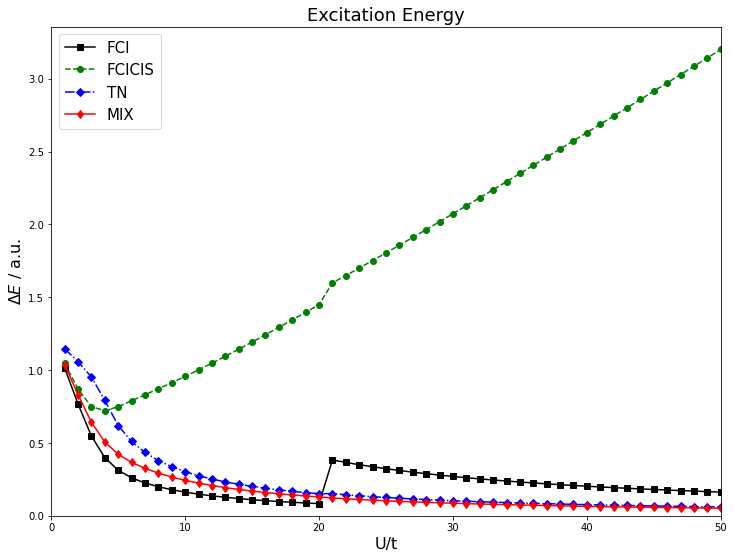

In [20]:
plt.figure(figsize=(12, 9))


plt.plot(df['U'], df['ext-FCI'], label='FCI', color='black', marker='s')
plt.plot(df['U'], df['ext-EOM'], label='FCICIS', color='green', linestyle='--', marker='o')
plt.plot(df['U'], df['ext-TN'], label='TN', color='blue', linestyle='-.', marker='D')
plt.plot(df['U'], df['ext-MIX'], linestyle='solid', marker='d', label='MIX', color='red')
plt.legend(fontsize=15)
plt.xlabel(r"U/t", fontsize=16)
plt.ylabel(r'$\Delta E$ / a.u.', fontsize=16)
plt.xlim(0,50)
plt.ylim(0)
plt.title("Excitation Energy", fontsize=18)
plt.show()

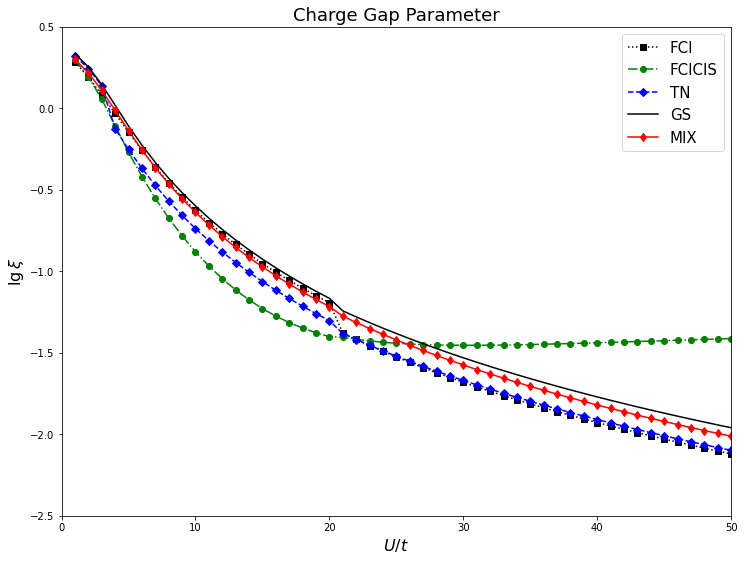

In [24]:
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(df['U'], np.log10(df['int-FCI']), label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], np.log10(df['int-EOM']), label='FCICIS', linestyle='-.', color='green', marker='o')
plt.plot(df['U'], np.log10(df['int-TN']), label='TN', linestyle='--', color='blue', marker='D')
plt.plot(df['U'], np.log10(df['int-GS']), label='GS', linestyle='solid', color='black')
plt.plot(df['U'], np.log10(df['int-MIX']), linestyle='solid', marker='d', label='MIX', color='red')
plt.xlabel(r"$U/t$", fontsize=16)
plt.ylabel(r"$\lg \xi$", fontsize=16)
plt.legend(fontsize=15)
plt.title("Charge Gap Parameter", fontsize=18)
plt.ylim(-2.5,0.5)
plt.xlim(0,50)
plt.show()

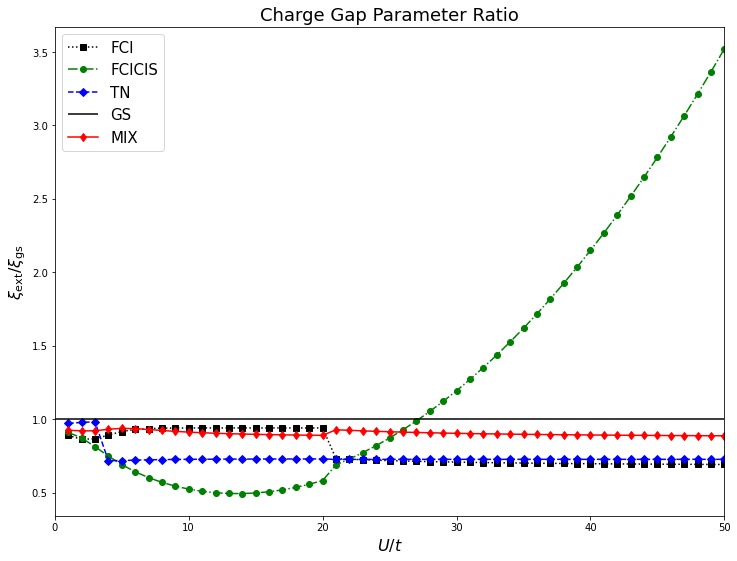

In [25]:
import numpy as np

plt.figure(figsize=(12,9))
plt.plot(df['U'], df['int-FCI']/df['int-GS'], label='FCI', linestyle=':', color='black', marker='s')
plt.plot(df['U'], df['int-EOM']/df['int-GS'], label='FCICIS', linestyle='-.', color='green', marker='o')
plt.plot(df['U'], df['int-TN']/df['int-GS'], label='TN', linestyle='--', color='blue', marker='D')
plt.hlines(1,0,50,color='black', label='GS')
plt.plot(df['U'], df['int-MIX']/df['int-GS'], linestyle='solid', marker='d', label='MIX', color='red')
plt.xlabel(r"$U/t$", fontsize=16)
plt.ylabel(r"$\xi_{\mathrm{ext}} / \xi_{\mathrm{gs}}$", fontsize=16)
plt.legend(fontsize=15)
plt.title("Charge Gap Parameter Ratio", fontsize=18)
plt.xlim(0,50)
plt.show()